In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.dask

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn import metrics

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, SSHCluster
import dask.distributed

import dask_ml
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import LabelEncoder

import xgboost as xgb

In [2]:
cluster = SSHCluster(["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                    )

2023-06-25 18:33:57,667 - distributed.deploy.ssh - INFO - 2023-06-25 18:33:57,665 - distributed.scheduler - INFO - State start
2023-06-25 18:33:57,672 - distributed.deploy.ssh - INFO - 2023-06-25 18:33:57,667 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-3nl2idzm', purging
2023-06-25 18:33:57,676 - distributed.deploy.ssh - INFO - 2023-06-25 18:33:57,675 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-25 18:33:58,702 - distributed.deploy.ssh - INFO - 2023-06-25 18:33:58,700 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:45709'
2023-06-25 18:33:58,720 - distributed.deploy.ssh - INFO - 2023-06-25 18:33:58,719 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35851'
2023-06-25 18:33:58,725 - distributed.deploy.ssh - INFO - 2023-06-25 18:33:58,724 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:34887'
2023-06-25 18:33:58,733 -

In [3]:
client=Client(cluster)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+------------------+
| Package | Client | Scheduler | Workers          |
+---------+--------+-----------+------------------+
| tornado | 6.3.2  | 6.3.2     | {'6.3.2', '6.2'} |
+---------+--------+-----------+------------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [4]:
q_drop = 0.2

#import data
bhbh = dd.read_parquet('/home/ubuntu/data/bag_all_dataset_with_no_kick/*')
bhbh = bhbh[bhbh['q']>q_drop]

In [5]:
#add column label
# n_bins = int(np.sqrt(len(bhbh)))
n_bins=50

# Define the edges between bins
counts, bin_edges = da.histogram(bhbh.q.values, bins=n_bins, range=(q_drop,1.0))

# pd.cut each column, with each bin closed on left and open on right
bhbh['label'] = bhbh['q'].map_partitions(pd.cut, bin_edges, right=True, labels=False, include_lowest=False)

In [6]:
print('bin_edges:', len(bin_edges))
print(counts)

bin_edges: 51
dask.array<sum-aggregate, shape=(50,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>


In [7]:
bhbh_train, bhbh_test=train_test_split(bhbh, train_size=0.8, shuffle=True)

In [8]:
bhbh_train=bhbh_train.reset_index(drop=True) # just for simplicity sake in the final visualisation
bhbh_test=bhbh_test.reset_index(drop=True)   # and so that we don't mess up later when checking the results

In [9]:
# len(bhbh_train) # check number of records

In [10]:
bhbh_train=bhbh_train.repartition(120)

In [11]:
# len(bhbh_train) # check consistency after repartitioning

In [11]:
countings=bhbh_train['label'].to_frame().groupby('label').size().compute()

In [12]:
total_counts=countings.sum()

In [13]:
n_bins

50

In [14]:
def assign_weight(i):
    return total_counts/(n_bins*countings[i])

In [15]:
bhbh_train['weight']=bhbh_train['label'].map(assign_weight)

In [17]:
# bhbh_train.hvplot.scatter('label', 'weight') # cool but heavy graphics; keep commented

In [18]:
# labs_weights=bhbh_train[['label', 'weight']].compute()
# plt.scatter(x=labs_weights.label, y=labs_weights.weight)
# plt.xlabel('label')
# plt.ylabel('weight')
# plt.savefig('labels_vs_weight.png')

In [16]:
weights=bhbh_train['weight']
labels=bhbh_train['label']
features=bhbh_train[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]

In [17]:
features_test=bhbh_test[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]
label_test=bhbh_test['label']

In [18]:
type(features), features.npartitions

(dask.dataframe.core.DataFrame, 120)

In [19]:
type(labels), labels.npartitions

(dask.dataframe.core.Series, 120)

In [20]:
#parameters
n_estimators = 10
max_depth = 8
learning_rate = 0.3
grow_policy = 'lossguide'
max_leaves = 10

param = {'objective': 'multi:softprob',
        'grow_policy' : 'lossguide', 
        # 'n_estimators' : n_estimators, 
        'max_depth' : max_depth,
        'learning_rate' : learning_rate,
        'max_leaves' : n_bins,
        'num_class': n_bins,
        # 'n_jobs' : -1
        }

In [21]:
dtrain = xgb.dask.DaskDMatrix(client, features, label=labels, weight=weights)

In [22]:
# train XGB
bst = xgb.dask.train(client, param, dtrain, num_boost_round=2, evals=[(dtrain, "train")])

In [26]:
bst=bst['booster']

In [ ]:
output=xgb.dask.predict(client,bst,dtrain)
output = output.to_dask_dataframe()

In [ ]:
output.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.013517,0.013579,0.016640,0.013884,0.013898,0.013860,0.014745,0.013768,0.013710,0.013575,...,0.020796,0.020983,0.030367,0.034680,0.042476,0.038159,0.041349,0.047000,0.037568,0.077289
1,0.016988,0.012436,0.012106,0.012805,0.012437,0.012059,0.012213,0.014004,0.014205,0.017244,...,0.012700,0.012531,0.012731,0.012633,0.012777,0.012507,0.012709,0.013084,0.012898,0.012691
2,0.013588,0.013649,0.013757,0.013721,0.013683,0.013780,0.013866,0.013839,0.013782,0.013646,...,0.037364,0.040315,0.041861,0.045046,0.046284,0.030785,0.031654,0.024677,0.027018,0.018239
3,0.015413,0.015483,0.015605,0.015565,0.015521,0.015632,0.015584,0.015699,0.015633,0.015479,...,0.017733,0.021380,0.017206,0.024033,0.021921,0.019167,0.018967,0.017265,0.017019,0.016747
4,0.017056,0.016048,0.016284,0.015772,0.015787,0.015745,0.015894,0.015639,0.015574,0.015421,...,0.023623,0.023836,0.023791,0.026980,0.027078,0.026967,0.027835,0.032972,0.022538,0.024385


In [ ]:
output_pd=output.head()

In [ ]:
output_pd.sum(axis=1) # check that it is a pdf

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float32

In [ ]:
output_pd.idxmax(axis=1) # compute the most likely label

0    49
1    30
2    44
3    32
4    47
dtype: int64

In [ ]:
output_pd

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.013517,0.013579,0.016640,0.013884,0.013898,0.013860,0.014745,0.013768,0.013710,0.013575,...,0.020796,0.020983,0.030367,0.034680,0.042476,0.038159,0.041349,0.047000,0.037568,0.077289
1,0.016988,0.012436,0.012106,0.012805,0.012437,0.012059,0.012213,0.014004,0.014205,0.017244,...,0.012700,0.012531,0.012731,0.012633,0.012777,0.012507,0.012709,0.013084,0.012898,0.012691
2,0.013588,0.013649,0.013757,0.013721,0.013683,0.013780,0.013866,0.013839,0.013782,0.013646,...,0.037364,0.040315,0.041861,0.045046,0.046284,0.030785,0.031654,0.024677,0.027018,0.018239
3,0.015413,0.015483,0.015605,0.015565,0.015521,0.015632,0.015584,0.015699,0.015633,0.015479,...,0.017733,0.021380,0.017206,0.024033,0.021921,0.019167,0.018967,0.017265,0.017019,0.016747
4,0.017056,0.016048,0.016284,0.015772,0.015787,0.015745,0.015894,0.015639,0.015574,0.015421,...,0.023623,0.023836,0.023791,0.026980,0.027078,0.026967,0.027835,0.032972,0.022538,0.024385


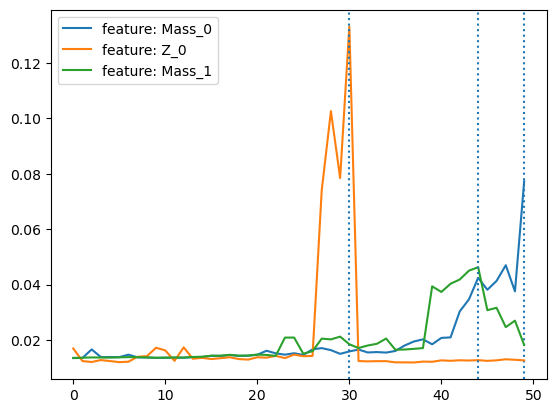

In [ ]:
# plot the pdf and show the maximum
def print_pdf(index):
    plt.plot(output_pd.loc[index])
    plt.axvline(x=np.argmax(output_pd.loc[index]), linestyle ='dotted')
    plt.legend()
    
print_pdf(0)
print_pdf(1)
print_pdf(2)
plt.show()

In [40]:
predicted_label=output.idxmax(axis=1)

In [41]:
type(predicted_label)

dask.dataframe.core.Series

In [42]:
label_test.head()

0    46
1    28
2    41
3    32
4    47
Name: label, dtype: int64

In [43]:
predicted_label.head()

0    49
1    30
2    44
3    32
4    47
dtype: int64

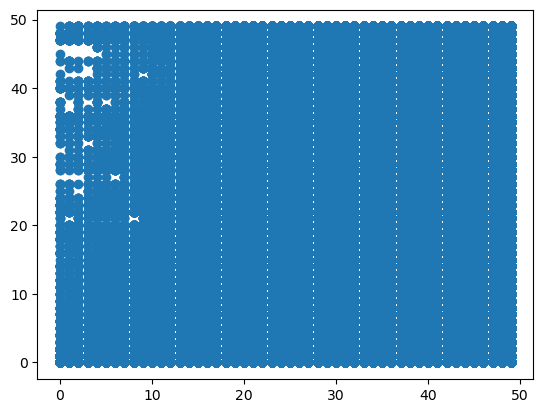

In [44]:
plt.scatter(label_test, predicted_label)

In [53]:
predicted_label.hvplot.hist(bins=n_bins)+ label_test.hvplot.hist(bins=n_bins)

:Layout
   .Histogram.I  :Histogram   [0]   (0_count)
   .Histogram.II :Histogram   [label]   (label_count)

In [45]:
type(label_test), label_test

(dask.dataframe.core.Series,
 Dask Series Structure:
 npartitions=1800
     int64
       ...
     ...  
       ...
       ...
 Name: label, dtype: int64
 Dask Name: getitem, 10 graph layers)

In [ ]:
# label_test=label_test.reset_index(drop=False)
# predicted_label=predicted_label.reset_index(drop=False)

In [ ]:
# label_test.merge( predicted_label, how='inner', on='index').head()

In [ ]:
# labels.reset_index(drop=False).head()

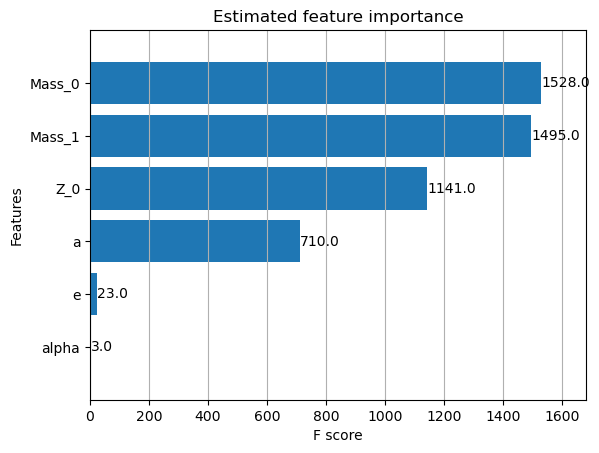

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgb.plot_importance(bst['booster'], height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [47]:
y_train_predict = model.predict(X_train)
#prediction = le.inverse_transform(prediction)

AttributeError: 'dict' object has no attribute 'predict'

In [ ]:
y_train_predict.shape, X_train.shape

In [ ]:
plt.hist(y_train_predict, bins=n_bins, alpha=1, label='predict')
plt.hist(y_train, alpha=0.5, bins=n_bins, label='labels')
plt.legend()

In [ ]:
prob_y_train_pred = model.predict_proba(X_train)
prob_y_train_pred.shape

k = 5
plt.plot(range(0,n_bins), prob_y_train_pred[k])
print(y[k], y_train_predict[k])

In [ ]:
y_test_pred = model.predict(X_test)
#y_pred = le.inverse_transform(y_pred)
cm = confusion_matrix(y_test, y_test_pred)
# print(cm)

# print(accuracy_score(y_test, y_test_pred, normalize=True))
# print(accuracy_score(y_train, y_train_predict))

In [50]:
prob_y_test_pred = model.predict_proba(X_test)
plt.plot(range(0, n_bins), prob_y_test_pred[2])

Task exception was never retrieved
future: <Task finished name='Task-8733' coro=<Client._gather.<locals>.wait() done, defined at /home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit


NameError: name 'model' is not defined

In [ ]:
label_values = np.arange(0, n_bins)

In [ ]:
y_test_label_predict_max = np.argmax(prob_y_test_pred, axis=1)
plt.scatter(y_test, y_test_label_predict_max, s=0.1)
plt.plot(y_test, y_test, color='red')
plt.xlabel('y_tes')
plt.ylabel('y_test_label_predict_max')

In [ ]:
y_test_label_predict_mean = np.sum(prob_y_test_pred*(label_values), axis=1)
y_test_label_predict_variance = np.sum(prob_y_test_pred * (label_values.reshape(1,n_bins) - y_test_label_predict_mean.reshape(len(y_test_label_predict_mean), 1))**2, axis=1)
y_test_label_predict_std = np.sqrt(y_test_label_predict_variance)

plt.errorbar(y_test[:100], y_test_label_predict_mean[:100], yerr=y_test_label_predict_std[:100], fmt='.')
plt.plot(y_test[:100], y_test[:100], color='red')
# plt.errorbar(y_test, y_test_label_predict_mean, yerr=y_test_label_predict_std, fmt='.')
# plt.plot(y_test, y_test, color='red')
plt.xlabel('y_tes')
plt.ylabel('y_test_label_predict_mean')

In [ ]:
plt.scatter(y_test, y_test_label_predict_mean, s=0.1)
plt.plot(y_test, y_test, color='red')
plt.xlabel('y_tes')
plt.ylabel('y_test_label_predict_mean')

In [ ]:
chi = np.sum(((y_test_label_predict_mean - y_test)**2)/y_test_label_predict_variance)
chi_norm = chi/len(y_test)
print(chi)
print(chi_norm)

In [ ]:
import seaborn as sns

In [ ]:
sns.scatterplot(x=y_test, y=y_test_label_predict_max, hue = X_test['Z_1'], s=1)